# TASK 1 first approach

In [4]:
# Alternative way to launch Spark environment
!pip install -q pyspark

In [8]:
!pip install findspark

In [1]:
# Run this code to setup the environment
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3" # remember to set the right path!

os.environ["JAVA_HOME"] = "/usr/local/Cellar/openjdk/18.0.2.1/libexec/openjdk.jdk/Contents/Home"
os.environ["SPARK_HOME"] = "/usr/local/Cellar/apache-spark/3.3.0/libexec" 

In [2]:
# import libraries

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import date, timedelta, datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
# setup our Spark session

import findspark
from pyspark.sql import *

findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.appName("Alkemy")\
.config ("spark.sql.shuffle.partitions", "50")\
.config("spark.driver.maxResultSize","5g")\
.config ("spark.sql.execution.arrow.enabled", "true")\
.getOrCreate()

# Import of data

In [4]:
# define the schemes for each dataset

sales_schema = StructType() \
      .add("sale_date",DateType(),True) \
      .add("product_id",IntegerType(),True) \
      .add("quantity",IntegerType(),True) \
      .add("sales_price",DoubleType(),True) \
      .add("regular_price",DoubleType(),True) \
      .add("purchase_price",DoubleType(),True) 

stock_schema = StructType() \
      .add("stock_date",DateType(),True) \
      .add("product_id",IntegerType(),True) \
      .add("total_stock",IntegerType(),True) 

clicks_schema = StructType() \
      .add("date",TimestampType(),True) \
      .add("seller",IntegerType(),True) \
      .add("position",IntegerType(),True) \
      .add("price_max",DoubleType(),True) \
      .add("price_min",DoubleType(),True) \
      .add("price",DoubleType(),True) \
      .add("type",StringType(),True) \
      .add("product_id",IntegerType(),True) 

prices_competitor_schema = StructType() \
      .add("comp_date",DateType(),True) \
      .add("seller_id",IntegerType(),True) \
      .add("product_id",IntegerType(),True) \
      .add("price",DoubleType(),True) 

product_catalog_schema = StructType() \
      .add("product_id",IntegerType(),True) \
      .add("coded_cat1",IntegerType(),True) \
      .add("coded_cat2",IntegerType(),True) \
      .add("coded_cat3",IntegerType(),True) \
      .add("coded_brand",IntegerType(),True) \
      .add("coded_name",IntegerType(),True) 


In [5]:
# import of csv files

sales_data        = sc.read.csv('/users/anastasia/Documents/LUISS/Big_Data/progetto_Alkemy/all/sales_data.csv',       header=True, dateFormat="dd-MM-YYYY", schema=sales_schema)
stock             = sc.read.csv('/users/anastasia/Documents/LUISS/Big_Data/progetto_Alkemy/all/stock.csv',            header=True, dateFormat="dd-MM-YYYY", schema=stock_schema)
clicks_bidding    = sc.read.csv('/users/anastasia/Documents/LUISS/Big_Data/progetto_Alkemy/all/clicks_bidding.csv',   header=True, dateFormat="dd-MM-YYYY HH:mm:ss", schema=clicks_schema)
clicks_regular    = sc.read.csv('/users/anastasia/Documents/LUISS/Big_Data/progetto_Alkemy/all/clicks_regular.csv',   header=True, dateFormat="dd-MM-YYYY HH:mm:ss", schema=clicks_schema)
prices_competitor = sc.read.csv('/users/anastasia/Documents/LUISS/Big_Data/progetto_Alkemy/all/prices_competitor.csv',header=True, dateFormat="dd-MM-YYYY", schema=prices_competitor_schema)
product_catalog   = sc.read.csv('/users/anastasia/Documents/LUISS/Big_Data/progetto_Alkemy/all/product_catalog.csv', header=True, schema=product_catalog_schema)

# sellerslist =sc.read.csv("/users/anastasia/Documents/LUISS/Big Data/progetto Alkemy/sampled/sellers_list.csv")



In [6]:
sales_data.show(5)
sales_data.count()

+----------+----------+--------+-----------+-------------+--------------+
| sale_date|product_id|quantity|sales_price|regular_price|purchase_price|
+----------+----------+--------+-----------+-------------+--------------+
|2021-01-02|    109751|       1|     2499.0|       2777.0|        2082.0|
|2021-01-02|    110853|       1|     3990.0|       8322.0|        3325.0|
|2021-01-02|    131410|       1|     2288.0|       3767.0|        1907.0|
|2021-01-02|    134294|       1|     4990.0|       6666.0|        4158.0|
|2021-01-02|    134298|       1|     5990.0|       7777.0|        4992.0|
+----------+----------+--------+-----------+-------------+--------------+
only showing top 5 rows



119125

In [7]:
stock.show(5)
stock.count()

+----------+----------+-----------+
|stock_date|product_id|total_stock|
+----------+----------+-----------+
|2021-09-14|    136195|         12|
|2021-12-15|    121479|          4|
|2021-02-18|    133076|         52|
|2021-04-10|    160615|         20|
|2021-08-24|    100204|         24|
+----------+----------+-----------+
only showing top 5 rows



2289730

In [8]:
clicks_bidding.show(5)
clicks_bidding.count()

+-------------------+------+--------+---------+---------+-------+-------+----------+
|               date|seller|position|price_max|price_min|  price|   type|product_id|
+-------------------+------+--------+---------+---------+-------+-------+----------+
|2021-04-02 11:48:02|    48|       1|  25990.0|  21990.0|25990.0|Bidding|    140476|
|2021-04-02 11:48:04|   180|       1|  51990.0|  42989.0|45490.0|Bidding|    123606|
|2021-04-02 11:48:15|    24|       1|  53990.0|  48789.0|38790.0|Bidding|    157285|
|2021-04-02 11:48:16|    48|       1|  10699.0|   8450.0| 8990.0|Bidding|    113103|
|2021-04-02 11:48:59|    24|       1|  67199.0|  67199.0|55990.0|Bidding|    151375|
+-------------------+------+--------+---------+---------+-------+-------+----------+
only showing top 5 rows



696999

In [9]:
clicks_regular.show(5)
clicks_regular.count()

+-------------------+------+--------+---------+---------+-----+-------+----------+
|               date|seller|position|price_max|price_min|price|   type|product_id|
+-------------------+------+--------+---------+---------+-----+-------+----------+
|2020-01-01 00:28:01|    48|    null|   5290.0|   5290.0| null|Regular|    148875|
|2020-01-01 00:29:40|    48|    null|  11787.0|   9990.0| null|Regular|    104538|
|2020-01-01 00:30:39|    23|    null|  16217.0|  16217.0| null|Regular|    108283|
|2020-01-01 00:42:23|    48|    null|   7399.0|   6398.0| null|Regular|    144718|
|2020-01-01 00:42:51|   407|    null|   3343.0|   2299.0| null|Regular|    144776|
+-------------------+------+--------+---------+---------+-----+-------+----------+
only showing top 5 rows



2252931

In [10]:
prices_competitor.show(5)
prices_competitor.count()

+----------+---------+----------+-------+
| comp_date|seller_id|product_id|  price|
+----------+---------+----------+-------+
|2021-01-01|       23|    110064|27990.0|
|2021-01-01|       24|    110064|27990.0|
|2021-01-01|       26|    110064|27990.0|
|2021-01-01|       41|    110064|27490.0|
|2021-01-01|       48|    110064|27990.0|
+----------+---------+----------+-------+
only showing top 5 rows



8473036

In [11]:
product_catalog.show(5)
product_catalog.count()

+----------+----------+----------+----------+-----------+----------+
|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+----------+----------+----------+-----------+----------+
|    109844|      1776|      1504|       732|        367|      1539|
|    119374|      1776|      1504|       732|        367|      1748|
|    131012|      1776|      1504|      1907|        367|      2849|
|    131031|      1776|      1504|      1907|        367|      2841|
|    131306|      1776|      1504|      1907|        213|      2745|
+----------+----------+----------+----------+-----------+----------+
only showing top 5 rows



7529

# Data cleaning

In [12]:
# on clickregular there are records of 2020 and 2022 that we need to esclude: keep only 2021

clicks_regular = clicks_regular[(clicks_regular['date'] <= pd.to_datetime("2021-12-31").date()) & (clicks_regular['date'] >= pd.to_datetime("2021-01-01").date())]


In [13]:
# on clickregular there are records of 2020 and 2022 that we need to esclude: keep only 2021

clicks_bidding = clicks_bidding[(clicks_bidding['date'] <= pd.to_datetime("2021-12-31").date()) & (clicks_bidding['date'] >= pd.to_datetime("2021-01-01").date())]


In [14]:
# check for null
clicks_bidding.select([count(when(col(c).isNull(), c)).alias(c) for c in clicks_bidding.columns] ).show()


+----+------+--------+---------+---------+-----+----+----------+
|date|seller|position|price_max|price_min|price|type|product_id|
+----+------+--------+---------+---------+-----+----+----------+
|   0|     0|       0|        0|        0|    0|   0|         0|
+----+------+--------+---------+---------+-----+----+----------+



In [15]:
# check for null
clicks_regular.select([count(when(col(c).isNull(), c)).alias(c) for c in clicks_regular.columns] ).show()

# the column position is always NULL: ok 
# 6,6% of the records have the column prie at NULL:  for the moment we leave the records without overriding any value


+----+------+--------+---------+---------+-----+----+----------+
|date|seller|position|price_max|price_min|price|type|product_id|
+----+------+--------+---------+---------+-----+----+----------+
|   0|     0| 1230842|        0|        0|81124|   0|         0|
+----+------+--------+---------+---------+-----+----+----------+



In [16]:
# check for null
sales_data.select([count(when(col(c).isNull(), c)).alias(c) for c in sales_data.columns] ).show()


+---------+----------+--------+-----------+-------------+--------------+
|sale_date|product_id|quantity|sales_price|regular_price|purchase_price|
+---------+----------+--------+-----------+-------------+--------------+
|        0|         0|       0|          0|            0|             0|
+---------+----------+--------+-----------+-------------+--------------+



In [17]:
# check for null
stock.select([count(when(col(c).isNull(), c)).alias(c) for c in stock.columns] ).show()

+----------+----------+-----------+
|stock_date|product_id|total_stock|
+----------+----------+-----------+
|         0|         0|          0|
+----------+----------+-----------+



In [18]:
# check for null
prices_competitor.select([count(when(col(c).isNull(), c)).alias(c) for c in prices_competitor.columns] ).show()

+---------+---------+----------+-----+
|comp_date|seller_id|product_id|price|
+---------+---------+----------+-----+
|        0|        0|         0|    0|
+---------+---------+----------+-----+



In [19]:
# from this point on is more efficient to work in sql, so first of all register all tables

sales_data.createOrReplaceTempView("sales_data")
stock.createOrReplaceTempView("stock")
clicks_bidding.createOrReplaceTempView("clicks_bidding")
clicks_regular.createOrReplaceTempView("clicks_regular")
prices_competitor.createOrReplaceTempView("prices_competitor")
product_catalog.createOrReplaceTempView("product_catalog")


In [20]:
# in the prices_competitor table there are 8.473.038 record
# of which 1,080,721, on the same day, seller and product, have 2 records (2 different prices).
# these are the famous intraday variations that we had already encountered in task 0
# unfortunately they are not few and distort our analysis
# we have to find a way to purify them leaving only the new price

sc.sql("select sum(rec) from (select comp_date, seller_id, product_id, count(*) as rec from prices_competitor group by comp_date, seller_id, product_id having count(*)>1) a ").show(1000)


+--------+
|sum(rec)|
+--------+
| 1080721|
+--------+



In [21]:
# the number of records we need to get to after deleting duplicates is
# calculated by the query below 7,927,677

sc.sql("select count(*) from (select distinct comp_date, seller_id, product_id from prices_competitor) a ").show()


+--------+
|count(1)|
+--------+
| 7927677|
+--------+



In [22]:
# With the query below we can see all the data/seller/product combinations for which there is more than one price: there are 3 cases with 5 prices per day and then going down

# select comp_date, seller_id, product_id, count(*) as rec 
# from prices_competitor 
# group by comp_date, seller_id, product_id 
# having count(*) > 2 
# order by 4 desc
       
sc.sql("select comp_date, seller_id, product_id, count(*) as rec from prices_competitor group by comp_date, seller_id, product_id having count(*)>2 order by 4 desc").show(10)


+----------+---------+----------+---+
| comp_date|seller_id|product_id|rec|
+----------+---------+----------+---+
|2021-04-28|       41|    157256|  5|
|2021-05-21|       41|    147963|  5|
|2021-03-04|      180|    153413|  5|
|2021-02-12|       41|    132547|  4|
|2021-03-04|      180|    127498|  4|
|2021-02-12|       41|    121575|  4|
|2021-03-04|      180|    137167|  4|
|2021-02-12|       41|    157398|  4|
|2021-02-12|       41|    172241|  4|
|2021-02-17|       41|    142763|  4|
+----------+---------+----------+---+
only showing top 10 rows



In [23]:
# to better understand let's see the first case (5 prices on the same day): 
# may 2021 seller 41 and product 147963

#  select * 
#  from prices_competitor 
#  where   comp_date between '2021-05-15' and '2021-05-25' and
#          seller_id = 41 and
#          product_id=147963

sc.sql("select * from prices_competitor where comp_date between '2021-05-15' and '2021-05-25'and seller_id = 41 and product_id=147963").show(1000)


+----------+---------+----------+-------+
| comp_date|seller_id|product_id|  price|
+----------+---------+----------+-------+
|2021-05-15|       41|    147963|29391.0|
|2021-05-16|       41|    147963|29391.0|
|2021-05-17|       41|    147963|29391.0|
|2021-05-17|       41|    147963|30300.0|
|2021-05-17|       41|    147963|30790.0|
|2021-05-18|       41|    147963|30482.0|
|2021-05-18|       41|    147963|30790.0|
|2021-05-19|       41|    147963|30177.0|
|2021-05-19|       41|    147963|30482.0|
|2021-05-20|       41|    147963|29875.0|
|2021-05-20|       41|    147963|30177.0|
|2021-05-21|       41|    147963|29576.0|
|2021-05-21|       41|    147963|29875.0|
|2021-05-21|       41|    147963|35113.0|
|2021-05-21|       41|    147963|36199.0|
|2021-05-21|       41|    147963|36590.0|
|2021-05-22|       41|    147963|35113.0|
|2021-05-23|       41|    147963|35113.0|
|2021-05-24|       41|    147963|35113.0|
|2021-05-24|       41|    147963|36199.0|
|2021-05-25|       41|    147963|3

In [24]:
# since from Alkemy's indications the prices on clicks_bidding/regular are not reliable to eliminate
# duplicates we can only rely on the prices_competitor table: let's join it with
# itself by looking for cases and matches - with the same seller/product - between the prices of the day and those of the following day.
# With this system you eliminate most of the duplicates but a couple thousand cases remain. 
# To eliminate them in the select we group and we consider the mean.


strSQL = '        \
select prev.comp_date, prev.seller_id, prev.product_id, avg(prev.price) as price   \
from              \
(                 \
select *          \
from prices_competitor \
) prev            \
join              \
(                 \
select *          \
from prices_competitor \
) curr on curr.comp_date = dateadd(DAY,1,prev.comp_date) and \
  curr.seller_id         = prev.seller_id and                \
  curr.product_id        = prev.product_id and               \
  curr.price             = prev.price                        \
group by prev.comp_date, prev.seller_id, prev.product_id'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("test") 


In [25]:
# We put in the test table the first part of the new prices_competitor table without duplicates

sc.sql('select count(*) from test').show() 

+--------+
|count(1)|
+--------+
| 7482455|
+--------+



In [26]:
# The new "prices_competitor_new" consists of two parts: 
# 1.  the temporary table TEST created earlier 
# 2.  the query that comes after the union

strSQL = '  \
select *    \
from test   \
union all   \
select comp_date, seller_id, product_id, avg(price) as price \
from prices_competitor \
where not exists       \
 (select *             \
  from test            \
  where test.comp_date  = prices_competitor.comp_date  and   \
        test.seller_id  = prices_competitor.seller_id  and   \
        test.product_id = prices_competitor.product_id)      \
group by comp_date, seller_id, product_id'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("prices_competitor_new") 


In [27]:
sc.sql('select count(*) from prices_competitor_new').show()

# as we wanted to demonstrate this table now contains no more duplicates

+--------+
|count(1)|
+--------+
| 7927677|
+--------+



In [28]:
# let's go back to the example with 5 different prices in one

#  select * 
#  from prices_competitor 
#  where   comp_date between '2021-05-15' and '2021-05-25' and
#          seller_id = 41 and
#          product_id=147963

sc.sql("select * from prices_competitor where comp_date between '2021-05-15' and '2021-05-25'and seller_id = 41 and product_id=147963").show(1000)


+----------+---------+----------+-------+
| comp_date|seller_id|product_id|  price|
+----------+---------+----------+-------+
|2021-05-15|       41|    147963|29391.0|
|2021-05-16|       41|    147963|29391.0|
|2021-05-17|       41|    147963|29391.0|
|2021-05-17|       41|    147963|30300.0|
|2021-05-17|       41|    147963|30790.0|
|2021-05-18|       41|    147963|30482.0|
|2021-05-18|       41|    147963|30790.0|
|2021-05-19|       41|    147963|30177.0|
|2021-05-19|       41|    147963|30482.0|
|2021-05-20|       41|    147963|29875.0|
|2021-05-20|       41|    147963|30177.0|
|2021-05-21|       41|    147963|29576.0|
|2021-05-21|       41|    147963|29875.0|
|2021-05-21|       41|    147963|35113.0|
|2021-05-21|       41|    147963|36199.0|
|2021-05-21|       41|    147963|36590.0|
|2021-05-22|       41|    147963|35113.0|
|2021-05-23|       41|    147963|35113.0|
|2021-05-24|       41|    147963|35113.0|
|2021-05-24|       41|    147963|36199.0|
|2021-05-25|       41|    147963|3

In [29]:
# let's see how we see the same situation on the new table without duplicates

#  select * 
#  from prices_competitor_new 
#  where   comp_date between '2021-05-15' and '2021-05-25' and
#          seller_id = 41 and
#          product_id=147963

sc.sql("select * from prices_competitor_new where comp_date between '2021-05-15' and '2021-05-25'and seller_id = 41 and product_id=147963 order by 1").show(1000)


+----------+---------+----------+-------+
| comp_date|seller_id|product_id|  price|
+----------+---------+----------+-------+
|2021-05-15|       41|    147963|29391.0|
|2021-05-16|       41|    147963|29391.0|
|2021-05-17|       41|    147963|30790.0|
|2021-05-18|       41|    147963|30482.0|
|2021-05-19|       41|    147963|30177.0|
|2021-05-20|       41|    147963|29875.0|
|2021-05-21|       41|    147963|35113.0|
|2021-05-22|       41|    147963|35113.0|
|2021-05-23|       41|    147963|35113.0|
|2021-05-24|       41|    147963|36199.0|
|2021-05-25|       41|    147963|35837.0|
+----------+---------+----------+-------+



In [170]:
strSQL = '\
select comp_date, seller_id, product_id, count(*) \
from prices_competitor_new                        \
group by comp_date, seller_id, product_id         \
having count(*) > 1'

sc.sql(strSQL).show()


+---------+---------+----------+--------+
|comp_date|seller_id|product_id|count(1)|
+---------+---------+----------+--------+
+---------+---------+----------+--------+



# identify main competitors

In [30]:
# number of products sold  by our company
sc.sql("select count(distinct product_id) from sales_data").show()


+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                      7529|
+--------------------------+



In [31]:
# most sold products by our company
sc.sql("select product_id, sum(quantity) quantity_sold from sales_data group by product_id order by 2 desc").show()


+----------+-------------+
|product_id|quantity_sold|
+----------+-------------+
|    112582|          649|
|    110853|          646|
|    157318|          541|
|    125506|          445|
|    107645|          441|
|    136250|          413|
|    132408|          402|
|    157317|          359|
|    132284|          357|
|    142254|          355|
|    177925|          347|
|    103851|          335|
|    143220|          327|
|    157316|          324|
|    145377|          306|
|    110675|          305|
|    134358|          296|
|    112377|          295|
|    110908|          294|
|    128772|          293|
+----------+-------------+
only showing top 20 rows



In [32]:
# most sold products by our company grouped by coded_cat1 (cat 1 is the most aggregated)

#   select coded_cat1, sum(quantity) quantity_sold 
#   from sales_data join product_catalog on sales_data.product_id = product_catalog.product_id 
#   group by coded_cat1 
#   order by 2 desc

sc.sql("select coded_cat1, sum(quantity) quantity_sold from sales_data join product_catalog on sales_data.product_id = product_catalog.product_id group by coded_cat1 order by 2 desc").show()


+----------+-------------+
|coded_cat1|quantity_sold|
+----------+-------------+
|      2259|        39903|
|      1676|        37534|
|      2180|        17664|
|      1375|        16866|
|      1163|        12421|
|       885|         9002|
|      2880|         8774|
|      1776|         8698|
|       624|         5784|
|      1354|         4164|
|      1127|         3271|
|      1617|         1272|
+----------+-------------+



In [33]:
# most sold products by our company grouped by coded_cat2 (intermediate grouping)
sc.sql("select coded_cat2, sum(quantity) quantity_sold from sales_data join product_catalog on sales_data.product_id = product_catalog.product_id group by coded_cat2 order by 2 desc").show(100)


+----------+-------------+
|coded_cat2|quantity_sold|
+----------+-------------+
|      1714|        20699|
|       613|        14467|
|       944|        10623|
|      2005|        10184|
|      2832|         9139|
|      2193|         8983|
|      1069|         6643|
|      1267|         5096|
|      2519|         5069|
|      1376|         5014|
|      2015|         4887|
|      1246|         4677|
|      2291|         3983|
|      2218|         3909|
|      1412|         3694|
|      1600|         3580|
|       498|         3466|
|       834|         3197|
|      2856|         3050|
|      1054|         2863|
|      1564|         2772|
|       806|         2258|
|      1740|         2233|
|      1684|         2188|
|       821|         2143|
|      1760|         2021|
|      1567|         1793|
|       849|         1485|
|      1258|         1444|
|      1937|         1306|
|      1504|         1144|
|       953|         1038|
|       711|         1012|
|      1271|          941|
|

In [34]:
# most sold products by our company grouped by coded_cat3
sc.sql("select coded_cat3, sum(quantity) quantity_sold from sales_data join product_catalog on sales_data.product_id = product_catalog.product_id group by coded_cat3 order by 2 desc").show()


+----------+-------------+
|coded_cat3|quantity_sold|
+----------+-------------+
|      2467|         6890|
|      1753|         4932|
|       694|         4904|
|      2409|         4583|
|       493|         4537|
|      2275|         4377|
|       615|         3732|
|       732|         3689|
|       724|         3414|
|      1011|         2878|
|      1282|         2819|
|      1763|         2757|
|       601|         2704|
|      1273|         2636|
|      2431|         2619|
|      2668|         2600|
|       720|         2591|
|      2397|         2417|
|       548|         2295|
|      1176|         2236|
+----------+-------------+
only showing top 20 rows



In [35]:
# most sold products by our company grouped by coded_brand
sc.sql("select coded_brand, sum(quantity) quantity_sold from sales_data join product_catalog on sales_data.product_id = product_catalog.product_id group by coded_brand order by 2 desc").show(1000)


+-----------+-------------+
|coded_brand|quantity_sold|
+-----------+-------------+
|        522|        30037|
|        367|        16558|
|        253|        10057|
|        537|         7147|
|        289|         6607|
|        542|         5136|
|        453|         3161|
|        377|         2874|
|        279|         2663|
|        455|         2596|
|        691|         2510|
|        544|         2393|
|        392|         2180|
|        442|         1825|
|        621|         1721|
|        152|         1715|
|        237|         1631|
|        364|         1556|
|        601|         1484|
|        427|         1424|
|        147|         1420|
|        376|         1395|
|        329|         1324|
|        643|         1272|
|        358|         1264|
|        527|         1256|
|        325|         1252|
|        704|         1236|
|        304|         1219|
|        668|         1134|
|        521|         1060|
|        467|          989|
|        681|       

In [36]:
# let's try to understand the market share of the other competitors
# not having the sales data of the competitors the only way is to look at the number of clicks 
# we put together the 2 clicks tables via a UNION and then group by seller and product, counting the numer of clicks
# we have left the records with price at null (assuming that the user click was real)

#  select seller, product_id, count(*) num_clicks 
#  from
#     (
#     select seller, product_id
#     from clicks_bidding 
#     where seller <> 24
#     union all
#     select seller, product_id
#     from clicks_regular 
#     where seller <> 24
#     ) A
#  group by seller, product_id 
#  order by 1,2

sc.sql("select seller, product_id, count(*) num_clicks from (select seller, product_id from clicks_bidding where seller <> 24 union all select seller, product_id from clicks_regular where seller <> 24) A group by seller, product_id order by 1,2").show()


+------+----------+----------+
|seller|product_id|num_clicks|
+------+----------+----------+
|    23|    100208|         1|
|    23|    100212|         1|
|    23|    100404|         1|
|    23|    100406|         1|
|    23|    100409|         2|
|    23|    100421|         2|
|    23|    100426|         1|
|    23|    100594|         1|
|    23|    100621|         2|
|    23|    100625|         3|
|    23|    100633|         4|
|    23|    100645|         1|
|    23|    101074|         2|
|    23|    101767|         2|
|    23|    102342|        23|
|    23|    102362|         1|
|    23|    102367|         1|
|    23|    102528|         3|
|    23|    102626|         1|
|    23|    102746|         2|
+------+----------+----------+
only showing top 20 rows



In [37]:
# now let's join our sales data with the competitor clicks (the above result) 
# the join is a simple join (not right, not left) by product: because we want to compare the others on our same catalog

#  select A.product_id, A.quantity_sold, C.seller, C.num_clicks
#  from
#     (
#     select product_id, sum(quantity) quantity_sold 
#     from sales_data 
#     group by product_id 
#     ) A
#     join
#     (
#     select seller, product_id, count(*) num_clicks 
#     from
#        (
#        select seller, product_id
#        from clicks_bidding 
#        where seller <> 24
#        union all
#        select seller, product_id
#        from clicks_regular 
#        where seller <> 24
#        ) B
#     group by seller, product_id 
#     ) C
#     on A.product_id = C.product_id
#   order by 1,3

sc.sql("select A.product_id, A.quantity_sold, C.seller, C.num_clicks from (select product_id, sum(quantity) quantity_sold from sales_data group by product_id ) A join (select seller, product_id, count(*) num_clicks from (select seller, product_id from clicks_bidding where seller <> 24 union all select seller, product_id from clicks_regular where seller <> 24) B group by seller, product_id) C on A.product_id = C.product_id order by 1,3").show()


+----------+-------------+------+----------+
|product_id|quantity_sold|seller|num_clicks|
+----------+-------------+------+----------+
|    100043|            4|    26|         4|
|    100043|            4|    48|         2|
|    100044|            7|    26|         3|
|    100044|            7|    48|         1|
|    100078|           11|    26|         2|
|    100078|           11|    48|         1|
|    100078|           11|   188|         1|
|    100083|            4|    26|         7|
|    100083|            4|    48|         1|
|    100115|            4|   188|        17|
|    100122|            7|   407|         3|
|    100124|           37|   407|        10|
|    100204|            6|    26|         5|
|    100204|            6|    48|         1|
|    100205|            5|    26|         2|
|    100208|            4|    23|         1|
|    100208|            4|    26|         3|
|    100212|            6|    23|         1|
|    100212|            6|    26|         1|
|    10026

In [38]:
# to identify the big players just group the clicks of all sellers (filtered on our catalog)

#     select seller, count(*) num_clicks 
#     from
#        (
#        select seller, product_id
#        from clicks_bidding 
#        where seller <> 24 and product_id in (select distinct product_id from sales_data)
#        union all
#        select seller, product_id
#        from clicks_regular 
#        where seller <> 24 and product_id in (select distinct product_id from sales_data)
#        ) B
#     group by seller
#     order by 2 desc

sc.sql("select seller, count(*) num_clicks from (select seller, product_id from clicks_bidding where seller <> 24 and product_id in (select distinct product_id from sales_data) union all select seller, product_id from clicks_regular where seller <> 24 and product_id in (select distinct product_id from sales_data)) B group by seller order by 2 desc").show()


+------+----------+
|seller|num_clicks|
+------+----------+
|    26|    373325|
|    41|    230303|
|   180|    223932|
|   407|    162706|
|    48|    125441|
|   188|    108884|
|   490|     44071|
|    23|     29815|
+------+----------+



In [39]:
#  just a visualization of the prices of 1 single product (112582) in the 1st quarter 2021

df = sc.sql("select * from prices_competitor_new where comp_date >= '2021-01-01' and comp_date <= '2021-03-31' and product_id=112582 order by 1,2").toPandas() 

# graphs don't work on spark dataframes so we convert spark dataframe of query to pandas dataframe


/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


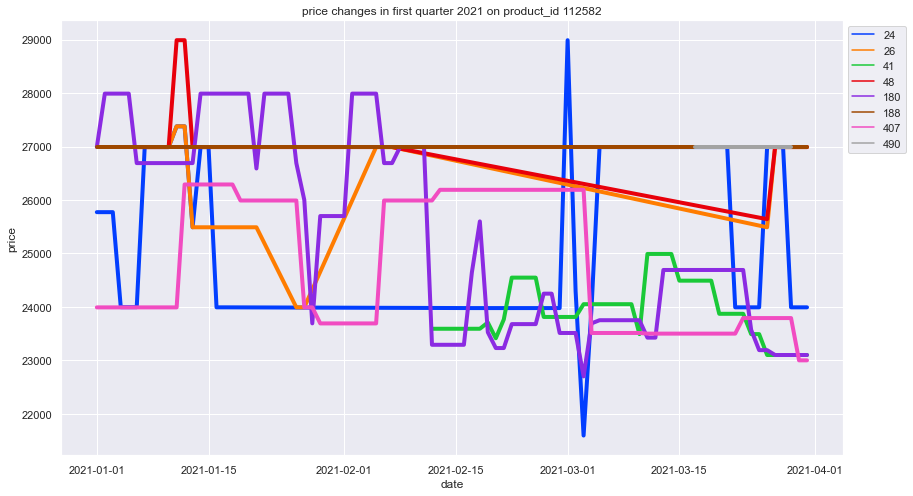

In [40]:
# plot with seaborn

sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df, 
                  x ='comp_date', y = 'price',
                  hue='seller_id', palette='bright',
                  legend='full', lw=4)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('price')
plt.xlabel('date')
plt.title('price changes in first quarter 2021 on product_id 112582')
plt.show()



# Leader and follower analysis Q1

The idea is to implement 3 steps:

1) create a new data frame "price_changes" with all price changes starting from prices_competitor: it
   will contain one record for each price change with date of change, price old, price new, seller and product
2) in this new dataframe identify all pairs of price changes with a time lag of 1 day (a different time lag can
   also be tried): in this way the first seller to change the price is considered the leader and the second the
   follower. the result of this step will be a new dataframe "leader_followers" with 6 columns: seller_leader, 
   seller_follower, product, date_of_price_change_leader, %price_chnage_leader, %price_change_follower
3) join all the price changes of a seller with the table created in the previuos step in order to check in how
   many cases the seller has been a leader, a follower or independent (this third case occurr when the seller
   change the price not in reaction to price movement of other competitors and at the same time after the price
   change nobody follows): as final result a dataframe will be produced with 4 columns: seller, %leader,
   %follower, %independent
   
With this final output should be easy to detect who are the leaders and who are the followers    

### step 1 - identify all price changes

In [42]:
# the idea is to join prices_competitor with itself: 2 pictures of the same data at a 1 day of distance 
# only when price change but the seller is the same and the product is the same

strSQL = '\
select  prev.comp_date prev_date, \
        prev.price prev_price, \
        curr.*, \
        case when curr.price > prev.price then "up" else "down" end direction   \
from      \
  (       \
  select *    \
  from prices_competitor_new   \
  where comp_date >= "2021-01-01" and    \
        comp_date <= "2021-03-31" and    \
        product_id in (select distinct product_id    \
                       from prices_competitor_new    \
                       where seller_id=24 and        \
                             comp_date >= "2021-01-01" and  \
                             comp_date <= "2021-03-31" )    \
  ) curr    \
  join      \
  (         \
  select *  \
  from prices_competitor_new     \
  where comp_date >= "2021-01-01" and    \
        comp_date <= "2021-03-31" and    \
        product_id in (select distinct product_id   \
                       from prices_competitor_new   \
                       where seller_id=24 and       \
                             comp_date >= "2021-01-01" and   \
                             comp_date <= "2021-03-31" )     \
  ) prev   \
  on       curr.product_id=prev.product_id   \
       and curr.seller_id=prev.seller_id     \
       and curr.price <> prev.price          \
       and dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_q1") 

# result of the query is saved to a table called price_changes_q1


In [43]:
sc.sql("select * from price_changes_q1").show(5)

+----------+----------+----------+---------+----------+-----+---------+
| prev_date|prev_price| comp_date|seller_id|product_id|price|direction|
+----------+----------+----------+---------+----------+-----+---------+
|2021-02-18|     433.5|2021-02-19|       24|    100043|459.0|       up|
|2021-01-27|     408.0|2021-01-28|       26|    100043|459.0|       up|
|2021-02-08|     459.0|2021-02-09|       26|    100043|433.0|     down|
|2021-03-09|     589.0|2021-03-10|       26|    100044|556.0|     down|
|2021-03-21|     530.0|2021-03-22|       48|    100044|589.0|       up|
+----------+----------+----------+---------+----------+-----+---------+
only showing top 5 rows



In [44]:
# We want to understand how the percentage price changes are distributed: does a change of 2 euros count or can we eliminate it?

df1 = sc.sql("select * from price_changes_q1").toPandas() 

/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [45]:

df1['price_change_perc'] = 100 * (df1['price'] - df1['prev_price'] ) / df1['prev_price']

In [171]:

df1[(df1['price_change_perc']>200) | (df1['price_change_perc']<-200) ]

# from the result we understand that there is some cleaning to be done (the price cannot go from 10 to 790 -> 10 is fake)

,prev_date,prev_price,comp_date,seller_id,product_id,price,direction,price_change_perc
22217,2021-02-25,1879.0,2021-02-26,26,160715,7073.5,up,276.450239
101876,2021-01-14,2.0,2021-01-15,26,137532,1290.0,up,64400.000000
108456,2021-01-19,489.0,2021-01-20,407,154037,2694.0,up,450.920245
136553,2021-02-25,1990.0,2021-02-26,48,160715,12990.0,up,552.763819
152547,2021-02-03,3670.0,2021-02-04,41,150533,15490.0,up,322.070845
163361,2021-03-30,1490.0,2021-03-31,23,111068,8999.0,up,503.959732
175942,2021-02-23,9435.0,2021-02-24,24,152356,32100.0,up,240.222576
177786,2021-03-16,21490.0,2021-03-17,41,155063,212590.0,up,889.250814
190040,2021-01-24,1990.0,2021-01-25,48,160715,12990.0,up,552.763819


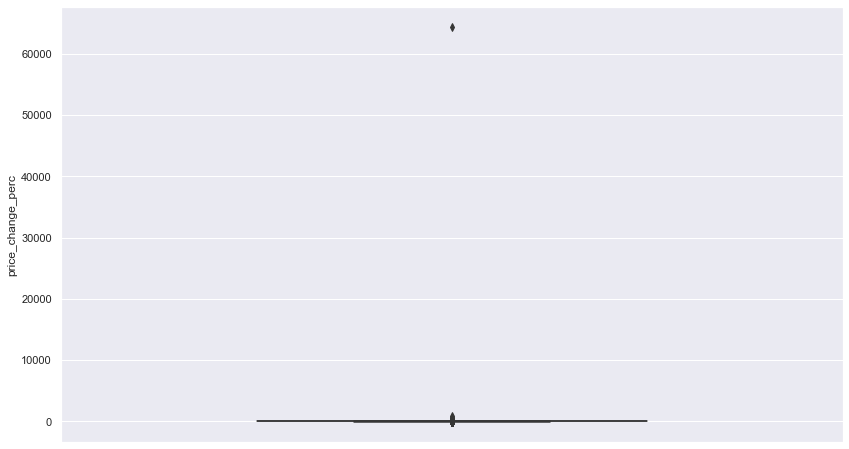

In [47]:

bplot = sns.boxplot(y='price_change_perc',  # x='continent', 
                 data=df1, 
                 width=0.5,
                 palette="colorblind")

plt.show()

# filtrando con variazione percentuale < 200 rimangono nella parte alta dei potenziali outliers
# filtering with a percentage change < 200 in the upper part remain some of the potential outliers

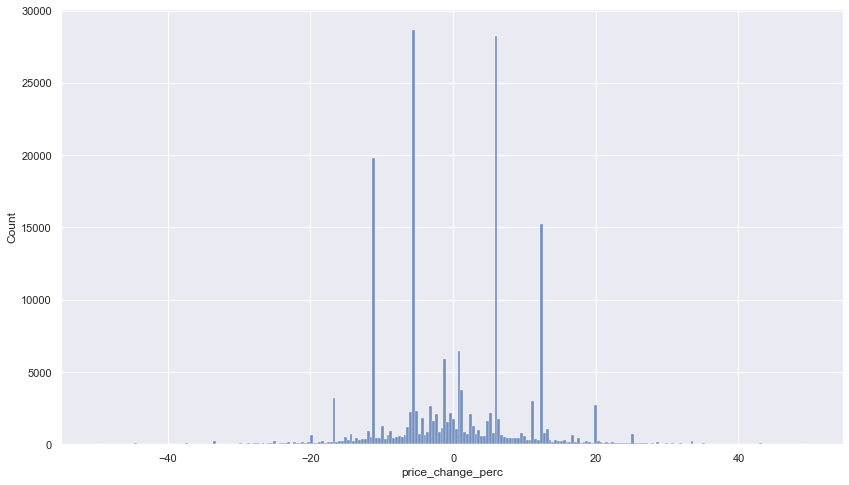

In [48]:
sns.histplot(data=df1[ (df1['price_change_perc']<50) & (df1['price_change_perc']>-50)], x="price_change_perc")
plt.show()

### step 2  - for each pairs of price changes distant 1 day time lag, identify leader and follower

In [49]:
# we re-apply the same idea of joining the new table price_changes_q1 with itself
# in this case same product, different seller, same direction (both sellers decrease or increase) and 
#  1 day of distance (this time lag could be changed for a deeper analysis)


strSQL = '\
select  prev.seller_id leader,  \
        curr.seller_id follower,  \
        curr.product_id,  \
        prev.comp_date date_leader,  \
        round(100*(prev.price-prev.prev_price)/prev.prev_price,2) price_change_leader,   \
        round(100*(curr.price-curr.prev_price)/curr.prev_price,2) price_change_follower  \
from  \
(select * from price_changes_q1) curr  \
join  \
(select * from price_changes_q1) prev  \
on  curr.product_id = prev.product_id and  \
    curr.direction = prev.direction and    \
    curr.seller_id <> prev.seller_id and   \
    dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("leader_followers_q1") 


# result of the query is saved to a table called leader_followers_q1


In [50]:
sc.sql("select * from leader_followers_q1").show(5)


+------+--------+----------+-----------+-------------------+---------------------+
|leader|follower|product_id|date_leader|price_change_leader|price_change_follower|
+------+--------+----------+-----------+-------------------+---------------------+
|    24|      48|    100044| 2021-03-26|               12.4|                 5.18|
|    24|      26|    100208| 2021-03-26|              12.49|                 5.88|
|    24|     180|    100405| 2021-03-26|              12.48|                16.89|
|    26|     180|    100421| 2021-01-28|              12.53|                 6.28|
|    26|     180|    100421| 2021-03-12|               5.86|                 6.28|
+------+--------+----------+-----------+-------------------+---------------------+
only showing top 5 rows



In [108]:
# let's analyse the results grouping for leader/followers the number of case we had in the 1st quarter

strSQL = '\
select  leader,    \
        follower,  \
        count(*) num_changes,  \
        count(distinct product_id) distinct_products,   \
        round(avg(price_change_leader),1)   avg_price_change_leader,    \
        round(avg(price_change_follower),1) avg_price_change_follower   \
from leader_followers_q1   \
group by leader, follower  \
order by 1,2'


sc.sql(strSQL).show(10)


+------+--------+-----------+-----------------+-----------------------+-------------------------+
|leader|follower|num_changes|distinct_products|avg_price_change_leader|avg_price_change_follower|
+------+--------+-----------+-----------------+-----------------------+-------------------------+
|    23|      24|         92|               89|                   -9.2|                     -8.7|
|    23|      26|         82|               80|                   -9.1|                     -5.2|
|    23|      41|         81|               73|                   -0.2|                      0.5|
|    23|      48|         43|               43|                  -15.3|                     -7.4|
|    23|     180|         97|               93|                    0.1|                      1.9|
|    23|     188|         19|               19|                    3.2|                     -0.5|
|    23|     407|         16|               16|                    4.8|                      4.1|
|    24|      23|   

In [52]:
sc.sql("select count(*) from price_changes_q1").show()

+--------+
|count(1)|
+--------+
|  190231|
+--------+



In [53]:
sc.sql("select count(*) from leader_followers_q1").show()

+--------+
|count(1)|
+--------+
|   40606|
+--------+



In [54]:
sc.sql("select count(*) from price_changes_q1 where seller_id=24").show()

+--------+
|count(1)|
+--------+
|   70411|
+--------+



In [98]:
# we group by leader and follower 

strSQL = '\
select  leader,   \
        follower, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q1              \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q1                                        \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q1                                        \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
group by  leader, follower \
order by 7 desc'

sc.sql(strSQL).show(1000)

+------+--------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------------+----------------+------------------+--------------+
|    41|     490|          1|                1|               1|                 1|         100.0|
|    48|     490|          2|                2|              13|                 2|         26.67|
|    48|      23|         29|               27|             180|                65|         23.67|
|    23|     188|         19|               19|              81|                84|         23.03|
|    23|      48|         43|               43|             140|               234|         22.99|
|    48|     188|        637|              541|            3214|              2419|         22.62|
|    41|     180|       3137|             1017|           11657|             16929|         21.95|
|   188|  

In [124]:
# same previous analysis but setting a threshold on price changes of 10%
strSQL = '\
select  leader,   \
        follower, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q1              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
group by  leader, follower \
order by 7 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------------+----------------+------------------+--------------+
|    41|      23|          2|                2|               2|                 2|         100.0|
|    41|     188|          2|                2|               2|                 4|         66.67|
|    41|     407|          5|                5|               6|                10|          62.5|
|    23|      41|          4|                4|               7|                 6|         61.54|
|   407|      41|         16|               15|              40|                20|         53.33|
|    23|     407|          5|                5|              14|                 8|         45.45|
|    48|     490|          2|                2|               7|                 2|         44.44|
|    41|  

In [131]:
# same previous analysis detailed for coded_brand (always with 10% threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q1              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_brand \
having sum(num_changes) > 10 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_brand|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|    26|     180|        279|         25|                9|              39|                36|         66.67|
|    26|     180|        591|         12|                6|              29|                18|         51.06|
|    26|      24|        549|         11|                5|              20|                24|          50.0|
|    48|     188|        348|         12|               12|              24|                24|          50.0|
|   180|     407|        522|         11|                9|              35|                11|         47.83|
|    41|     180|        522|         16|               16|              27|                40|         47.76|
|

In [141]:
# same previous analysis detailed for coded_cat3 (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q1              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3 \
having sum(num_changes) > 5 and \
    round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) > 30 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_cat3|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|    26|      41|      1262|          6|                3|              10|                 3|         92.31|
|    26|     180|       957|          7|                2|               9|                10|         73.68|
|    26|     180|      1410|          8|                3|              12|                14|         61.54|
|   188|     180|      1192|          7|                5|              12|                11|         60.87|
|    26|     180|      2715|         11|                4|              18|                19|         59.46|
|   180|      48|      1262|          9|                5|              21|                10|         58.06|
|    48|  

In [146]:
# same previous analysis detailed for coded_cat3 and brand (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) dist_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_foll, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q1              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q1                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3, coded_brand  \
having sum(num_changes) > 4 \
order by 9 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|leader|follower|coded_cat3|coded_brand|num_changes|dist_products|tot_pr_ch_leader|tot_pr_ch_foll|perc_lead_foll|
+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|    26|      41|      1262|        358|          5|            2|               8|             2|         100.0|
|    26|     180|      1753|        544|          5|            1|               8|             4|         83.33|
|   188|     180|      1192|        390|          5|            3|               6|             7|         76.92|
|    48|     188|      2467|        367|          5|            3|               7|             6|         76.92|
|    48|     188|      2830|        367|          8|            4|              14|             8|         72.73|
|   180|     407|      2169|        289|          5|            3|              10|     

### step 3 - flag all price changes in 3 categories: leader, follower, neither of the previous two

In [59]:
# The idea is to join all the price changes of a seller with the table created in the previuos step in order to 
# check in how many cases the seller has been a leader, a follower or independent (this third case occurr when 
# the seller change the price not in reaction to price movement of other competitors and at the same time after 
# the price change nobody follows).

# We do 2 left-join from the orignal price_changes table with 2 subtables (one for leader, one for followers): 
# with a nested case we identify the 3 cases

strSQL = '\
select tot.*, case when leader.comp_date is not null     \
                   then "L"        \
                   else            \
                        case when follower.comp_date is not null  \
                             then "F"    \
                             else "I"  \
                        end            \
              end as leader_follower   \
from price_changes_q1 tot              \
left join \
    ( \
    select distinct a.seller_id, a.product_id, a.comp_date\
    from price_changes_q1 a join leader_followers_q1 b  \
         on a.seller_id = b.leader and a.product_id = b.product_id and a.comp_date=b.date_leader  \
    ) leader  on    tot.seller_id = leader.seller_id and   \
                    tot.product_id= leader.product_id and  \
                    tot.comp_date = leader.comp_date      \
left join    \
    (   \
    select distinct a.seller_id, a.product_id, a.comp_date   \
    from price_changes_q1 a join leader_followers_q1 b       \
         on a.seller_id = b.follower and a.product_id = b.product_id and a.comp_date=DATEADD(DAY,1,b.date_leader) \
    ) follower  on  tot.seller_id = follower.seller_id and  \
                    tot.product_id= follower.product_id and  \
                    tot.comp_date = follower.comp_date '

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_new") 


In [100]:

sc.sql("select * from price_changes_new").show(5)            

# it is the original price_changes with one additional column on the right

+----------+----------+----------+---------+----------+------+---------+---------------+
| prev_date|prev_price| comp_date|seller_id|product_id| price|direction|leader_follower|
+----------+----------+----------+---------+----------+------+---------+---------------+
|2021-02-21|    1090.0|2021-02-22|       24|    100629|1029.0|     down|              I|
|2021-03-21|     266.0|2021-03-22|       26|    101074| 299.0|       up|              I|
|2021-03-11|     274.0|2021-03-12|       26|    102348| 290.0|       up|              I|
|2021-02-24|     746.0|2021-02-25|       24|    102369| 790.0|       up|              I|
|2021-01-25|     590.0|2021-01-26|       26|    102522| 524.0|     down|              L|
+----------+----------+----------+---------+----------+------+---------+---------------+
only showing top 5 rows



In [101]:
strSQL = '\
select seller_id, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new  \
group by seller_id      \
order by 2 desc' 

sc.sql(strSQL).show() 

# at the aggregate level it is not easy to say who is a leader and who is a follower

+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|      407|        24.4|        22.9|       52.7|     7301|       1783|       1670|      3848|
|       41|        24.3|        14.7|       61.0|    21140|       5142|       3105|     12893|
|      188|        20.4|        25.2|       54.4|     5009|       1020|       1264|      2725|
|      180|        19.3|        23.0|       57.7|    27063|       5221|       6232|     15610|
|       26|        18.4|         9.3|       72.3|    41657|       7673|       3879|     30105|
|       23|        18.3|        13.1|       68.6|     1635|        300|        214|      1121|
|       48|        14.8|        14.6|       70.6|    16011|       2375|       2337|     11299|
|       24|        12.3|         7.7|       80.1| 

In [105]:
# let's try to put a minimum threshold on price changes by taking only those > 10%
strSQL = '\
select seller_id, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new  \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id      \
order by 2 desc' 

sc.sql(strSQL).show() 

+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|       26|        30.5|         7.3|       62.2|    17158|       5229|       1254|     10675|
|       41|        26.7|        18.8|       54.5|      367|         98|         69|       200|
|      188|        20.1|        22.6|       57.3|     3165|        636|        714|      1815|
|       48|        20.0|         7.6|       72.4|     8098|       1621|        618|      5859|
|      407|        18.9|        24.5|       56.6|     1184|        224|        290|       670|
|       23|        17.1|        12.2|       70.7|      907|        155|        111|       641|
|      180|        16.6|        16.0|       67.4|     6171|       1027|        986|      4158|
|       24|        15.0|         4.9|       80.0| 

In [62]:
# let's see how the situation looks for the usual product 112582 (the best-selling by our company)
# we ad a "where product_id = 112582"

strSQL = '\
select seller_id, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new    \
where product_id = 112582 and abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id        \
order by 1' 

sc.sql(strSQL).show() 

# even on a single product the situation is not clear:


+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|       24|        50.0|        10.0|       40.0|       10|          5|          1|         4|
|      180|         0.0|         0.0|      100.0|        1|          0|          0|         1|
|      407|         0.0|       100.0|        0.0|        1|          0|          1|         0|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+



In [119]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_cat3, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new  join product_catalog on price_changes_new.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_cat3|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|      180|      1630|        75.0|         0.0|       25.0|        8|          6|          0|         2|
|       26|      2222|        71.4|         0.0|       28.6|        7|          5|          0|         2|
|       41|      2169|        71.4|        14.3|       14.3|        7|          5|          1|         1|
|       26|      1032|        63.6|         0.0|       36.4|       11|          7|          0|         4|
|       41|       805|        62.5|        25.0|       12.5|        8|          5|          2|         1|
|       26|      1262|        61.5|         1.9|       36.5|       52|         32|          1|        19|
|       26|       635|        61.5|         0.

In [158]:
# let's try to group by brand and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new  join product_catalog on price_changes_new.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       26|        380|        71.4|         0.0|       28.6|        7|          5|          0|         2|
|       26|        370|        66.7|         0.0|       33.3|        9|          6|          0|         3|
|       26|        594|        66.7|         3.3|       30.0|       30|         20|          1|         9|
|       26|        291|        66.7|        16.7|       16.7|        6|          4|          1|         1|
|       26|        476|        57.1|         0.0|       42.9|        7|          4|          0|         3|
|       48|        594|        55.6|         0.0|       44.4|        9|          5|          0|         4|
|       23|        498|        53.8| 

In [115]:
# let's try to group by cat3 and brand (always with threshold on price changes)

strSQL = '\
select seller_id, coded_cat3 as cat3, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new  join product_catalog on price_changes_new.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3 , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 4 desc' 

sc.sql(strSQL).show(20) 


+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|cat3|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       26|1616|        594|        85.7|         0.0|       14.3|        7|          6|          0|         1|
|       26|1630|        364|        85.7|         0.0|       14.3|        7|          6|          0|         1|
|       26|2431|        380|        83.3|         0.0|       16.7|        6|          5|          0|         1|
|       26|2668|        406|        77.8|         0.0|       22.2|        9|          7|          0|         2|
|       26| 548|        253|        77.8|         0.0|       22.2|        9|          7|          0|         2|
|       26|1065|        700|        75.0|         0.0|       25.0|        8|          6|          0|    

# 2021 QUARTER 2

In [116]:
# step 1

strSQL = '\
select  prev.comp_date prev_date, \
        prev.price prev_price, \
        curr.*, \
        case when curr.price > prev.price then "up" else "down" end direction   \
from      \
  (       \
  select *    \
  from prices_competitor_new   \
  where comp_date >= "2021-04-01" and    \
        comp_date <= "2021-06-30" and    \
        product_id in (select distinct product_id    \
                       from prices_competitor_new    \
                       where seller_id=24 and        \
                             comp_date >= "2021-04-01" and  \
                             comp_date <= "2021-06-30" )    \
  ) curr    \
  join      \
  (         \
  select *  \
  from prices_competitor_new     \
  where comp_date >= "2021-04-01" and    \
        comp_date <= "2021-06-30" and    \
        product_id in (select distinct product_id   \
                       from prices_competitor_new   \
                       where seller_id=24 and       \
                             comp_date >= "2021-04-01" and   \
                             comp_date <= "2021-06-30" )     \
  ) prev   \
  on       curr.product_id=prev.product_id   \
       and curr.seller_id=prev.seller_id     \
       and curr.price <> prev.price          \
       and dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_q2") 


In [117]:
# step 2

strSQL = '\
select  prev.seller_id leader,  \
        curr.seller_id follower,  \
        curr.product_id,  \
        prev.comp_date date_leader,  \
        round(100*(prev.price-prev.prev_price)/prev.prev_price,2) price_change_leader,   \
        round(100*(curr.price-curr.prev_price)/curr.prev_price,2) price_change_follower  \
from  \
(select * from price_changes_q2) curr  \
join  \
(select * from price_changes_q2) prev  \
on  curr.product_id = prev.product_id and  \
    curr.direction = prev.direction and    \
    curr.seller_id <> prev.seller_id and   \
    dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("leader_followers_q2") 


In [118]:
# step 3

strSQL = '\
select tot.*, case when leader.comp_date is not null     \
                   then "L"        \
                   else            \
                        case when follower.comp_date is not null  \
                             then "F"    \
                             else "I"  \
                        end            \
              end as leader_follower   \
from price_changes_q2 tot              \
left join \
    ( \
    select distinct a.seller_id, a.product_id, a.comp_date\
    from price_changes_q2 a join leader_followers_q2 b  \
         on a.seller_id = b.leader and a.product_id = b.product_id and a.comp_date=b.date_leader  \
    ) leader  on    tot.seller_id = leader.seller_id and   \
                    tot.product_id= leader.product_id and  \
                    tot.comp_date = leader.comp_date      \
left join    \
    (   \
    select distinct a.seller_id, a.product_id, a.comp_date   \
    from price_changes_q2 a join leader_followers_q2 b       \
         on a.seller_id = b.follower and a.product_id = b.product_id and a.comp_date=DATEADD(DAY,1,b.date_leader) \
    ) follower  on  tot.seller_id = follower.seller_id and  \
                    tot.product_id= follower.product_id and  \
                    tot.comp_date = follower.comp_date '

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_new_q2") 


In [133]:
# total analysis (with threshold on price changes at 10%)
strSQL = '\
select  leader,   \
        follower, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q2              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
group by  leader, follower \
order by 7 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------------+----------------+------------------+--------------+
|    23|      41|          2|                2|               2|                 2|         100.0|
|   490|      41|         12|               11|              20|                16|         66.67|
|    23|      24|          2|                2|               2|                 4|         66.67|
|    23|      48|          2|                2|               2|                 4|         66.67|
|    23|      26|          2|                2|               2|                 4|         66.67|
|   188|      41|         22|               17|              50|                21|         61.97|
|    41|     490|          3|                3|               7|                 5|          50.0|
|   490|  

In [137]:
# same previous analysis detailed for coded_brand (always with 10% threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q2              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_brand \
having sum(num_changes) > 10 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_brand|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|    24|      41|        775|         25|               11|              54|                11|         76.92|
|    48|      41|        775|         18|               11|              39|                11|          72.0|
|    26|      41|        775|         18|               11|              40|                11|         70.59|
|   490|     180|        522|         12|               12|              26|                14|          60.0|
|    26|      41|        542|         11|                8|              31|                11|         52.38|
|   180|      41|        775|         17|                9|              57|                 9|         51.52|
|

In [142]:
# same previous analysis detailed for coded_cat3 (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q2              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3 \
having sum(num_changes) > 5 and \
    round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) > 30 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_cat3|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|    24|      41|      1832|          8|                3|              16|                 3|         84.21|
|    24|      41|      1282|          7|                3|              14|                 3|         82.35|
|    26|      41|      1192|          7|                4|              13|                 6|         73.68|
|    26|      41|      4877|          9|                3|              23|                 3|         69.23|
|    48|      41|      1192|          6|                4|              12|                 6|         66.67|
|    24|      41|      1192|          6|                4|              12|                 6|         66.67|
|   180|  

In [147]:
# same previous analysis detailed for coded_cat3 and brand (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) dist_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_foll, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q2              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q2                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3, coded_brand  \
having sum(num_changes) > 4 \
order by 9 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|leader|follower|coded_cat3|coded_brand|num_changes|dist_products|tot_pr_ch_leader|tot_pr_ch_foll|perc_lead_foll|
+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|   180|      41|      1832|        775|          5|            2|               9|             2|         90.91|
|    24|      41|      1832|        775|          8|            3|              16|             3|         84.21|
|    24|      41|      1282|        775|          7|            3|              14|             3|         82.35|
|    26|      41|      4877|        522|          8|            2|              18|             2|          80.0|
|   188|      41|       615|        537|          5|            4|               8|             5|         76.92|
|    48|      41|      1273|        775|          5|            3|              10|     

In [172]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id,  \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q2  \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id      \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|      407|        15.4|        18.7|       65.9|     1330|        205|        249|       876|
|      490|        29.7|        17.6|       52.7|     1281|        381|        225|       675|
|      180|        17.4|        13.1|       69.5|     7186|       1247|        944|      4995|
|      188|        27.0|        13.0|       60.0|     1126|        304|        146|       676|
|       41|        18.5|        11.3|       70.2|      460|         85|         52|       323|
|       24|         9.3|         7.1|       83.6|    21229|       1980|       1509|     17740|
|       48|         9.2|         6.3|       84.5|    14865|       1371|        936|     12558|
|       26|         9.6|         5.5|       84.9| 

In [152]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_cat3, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q2  join product_catalog on price_changes_new_q2.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_cat3|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       41|      1282|        75.0|         0.0|       25.0|        8|          6|          0|         2|
|      490|      2830|        71.4|         0.0|       28.6|       21|         15|          0|         6|
|      490|       859|        68.2|         0.0|       31.8|       22|         15|          0|         7|
|      490|      2938|        66.7|         0.0|       33.3|        9|          6|          0|         3|
|      490|      2119|        66.7|         0.0|       33.3|        6|          4|          0|         2|
|       41|      1273|        62.5|         0.0|       37.5|        8|          5|          0|         3|
|      490|       495|        57.1|         0.

In [159]:
# let's try to group by brand and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q2  join product_catalog on price_changes_new_q2.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|      490|        364|        81.0|         9.5|        9.5|       21|         17|          2|         2|
|       41|        775|        66.7|        16.7|       16.7|       12|          8|          2|         2|
|      407|        329|        66.7|         0.0|       33.3|        6|          4|          0|         2|
|      490|        289|        65.7|         0.0|       34.3|      207|        136|          0|        71|
|      490|        459|        63.2|        10.5|       26.3|       19|         12|          2|         5|
|       41|        253|        50.0|         3.6|       46.4|       28|         14|          1|        13|
|      490|        253|        50.0| 

In [166]:
# let's try to group by cat3 and brand (always with threshold on price changes)

strSQL = '\
select seller_id, coded_cat3 as cat3, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q2  join product_catalog on price_changes_new_q2.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3 , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 4 desc' 

sc.sql(strSQL).show(20) 


+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|cat3|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|      490| 859|        459|       100.0|         0.0|        0.0|        7|          7|          0|         0|
|      490|1282|        289|       100.0|         0.0|        0.0|        6|          6|          0|         0|
|      490|2467|        289|        95.0|         0.0|        5.0|       20|         19|          0|         1|
|      490|2409|        253|        90.0|         0.0|       10.0|       10|          9|          0|         1|
|      490|1832|        289|        87.5|         0.0|       12.5|        8|          7|          0|         1|
|      490|2938|        289|        85.7|         0.0|       14.3|        7|          6|          0|    

# 2021 QUARTER 3

In [121]:
# step 1

strSQL = '\
select  prev.comp_date prev_date, \
        prev.price prev_price, \
        curr.*, \
        case when curr.price > prev.price then "up" else "down" end direction   \
from      \
  (       \
  select *    \
  from prices_competitor_new   \
  where comp_date >= "2021-07-01" and    \
        comp_date <= "2021-09-30" and    \
        product_id in (select distinct product_id    \
                       from prices_competitor_new    \
                       where seller_id=24 and        \
                             comp_date >= "2021-07-01" and  \
                             comp_date <= "2021-09-30" )    \
  ) curr    \
  join      \
  (         \
  select *  \
  from prices_competitor_new     \
  where comp_date >= "2021-07-01" and    \
        comp_date <= "2021-09-30" and    \
        product_id in (select distinct product_id   \
                       from prices_competitor_new   \
                       where seller_id=24 and       \
                             comp_date >= "2021-07-01" and   \
                             comp_date <= "2021-09-30" )     \
  ) prev   \
  on       curr.product_id=prev.product_id   \
       and curr.seller_id=prev.seller_id     \
       and curr.price <> prev.price          \
       and dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_q3") 


In [122]:
# step 2

strSQL = '\
select  prev.seller_id leader,  \
        curr.seller_id follower,  \
        curr.product_id,  \
        prev.comp_date date_leader,  \
        round(100*(prev.price-prev.prev_price)/prev.prev_price,2) price_change_leader,   \
        round(100*(curr.price-curr.prev_price)/curr.prev_price,2) price_change_follower  \
from  \
(select * from price_changes_q3) curr  \
join  \
(select * from price_changes_q3) prev  \
on  curr.product_id = prev.product_id and  \
    curr.direction = prev.direction and    \
    curr.seller_id <> prev.seller_id and   \
    dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("leader_followers_q3") 


In [123]:
# step 3

strSQL = '\
select tot.*, case when leader.comp_date is not null     \
                   then "L"        \
                   else            \
                        case when follower.comp_date is not null  \
                             then "F"    \
                             else "I"  \
                        end            \
              end as leader_follower   \
from price_changes_q3 tot              \
left join \
    ( \
    select distinct a.seller_id, a.product_id, a.comp_date\
    from price_changes_q3 a join leader_followers_q3 b  \
         on a.seller_id = b.leader and a.product_id = b.product_id and a.comp_date=b.date_leader  \
    ) leader  on    tot.seller_id = leader.seller_id and   \
                    tot.product_id= leader.product_id and  \
                    tot.comp_date = leader.comp_date      \
left join    \
    (   \
    select distinct a.seller_id, a.product_id, a.comp_date   \
    from price_changes_q3 a join leader_followers_q3 b       \
         on a.seller_id = b.follower and a.product_id = b.product_id and a.comp_date=DATEADD(DAY,1,b.date_leader) \
    ) follower  on  tot.seller_id = follower.seller_id and  \
                    tot.product_id= follower.product_id and  \
                    tot.comp_date = follower.comp_date '

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_new_q3") 


In [134]:
# total analysis (with threshold on price changes at 10%)

strSQL = '\
select  leader,   \
        follower, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q1              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
group by  leader, follower \
order by 7 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------------+----------------+------------------+--------------+
|    41|     407|          1|                1|               1|                 1|         100.0|
|    23|      24|          1|                1|               2|                 1|         66.67|
|   188|      41|          6|                5|              13|                 6|         63.16|
|   188|     407|         11|                9|              16|                20|         61.11|
|   407|      41|          6|                6|              17|                 6|         52.17|
|    23|     180|          1|                1|               2|                 2|          50.0|
|    41|     180|          5|                5|               6|                20|         38.46|
|    26|  

In [138]:
# same previous analysis detailed for coded_brand (always with 10% threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q3              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_brand \
having sum(num_changes) > 10 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_brand|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|   407|     180|        289|         21|               15|              33|                45|         53.85|
|    26|      41|        459|         12|                4|              43|                 5|          50.0|
|   407|      41|        522|         17|               15|              45|                23|          50.0|
|   407|      48|        147|         13|               13|              26|                27|         49.06|
|    26|     490|        522|         13|               13|              44|                14|         44.83|
|    48|      41|        459|         14|                4|              58|                 5|         44.44|
|

In [143]:
# same previous analysis detailed for coded_cat3 (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q3              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3 \
having sum(num_changes) > 5 and \
    round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) > 30 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_cat3|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|    48|      41|      2077|          6|                2|              20|                 2|         54.55|
|   180|      41|      2467|          6|                4|              17|                 5|         54.55|
|   407|      26|      2369|         11|                9|              27|                15|         52.38|
|   407|     180|      2938|          6|                5|              10|                13|         52.17|
|    41|     180|      2369|          7|                5|               8|                19|         51.85|
|    26|      24|      1062|          6|                5|              15|                 9|          50.0|
|    24|  

In [148]:
# same previous analysis detailed for coded_cat3 and brand (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) dist_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_foll, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q3              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q3                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3, coded_brand  \
having sum(num_changes) > 4 \
order by 9 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|leader|follower|coded_cat3|coded_brand|num_changes|dist_products|tot_pr_ch_leader|tot_pr_ch_foll|perc_lead_foll|
+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|    24|      41|      1282|        289|          5|            2|              11|             2|         76.92|
|    26|      41|      1616|        459|          5|            1|              14|             2|          62.5|
|   407|     180|      2467|        289|          9|            5|              13|            16|         62.07|
|    48|      41|      1616|        459|          5|            1|              16|             2|         55.56|
|   180|      41|      2467|        367|          5|            3|              14|             4|         55.56|
|    26|     180|      2369|        253|          5|            5|               5|     

In [173]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id,  \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q3  \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id      \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|      490|         9.2|        20.7|       70.1|      783|         72|        162|       549|
|       23|        25.9|        20.4|       53.7|       54|         14|         11|        29|
|       41|        21.3|        14.5|       64.2|      511|        109|         74|       328|
|      180|        15.7|        13.8|       70.5|     5322|        835|        734|      3753|
|      188|         4.7|        13.2|       82.1|     1771|         84|        233|      1454|
|       26|        12.4|        10.3|       77.3|    15221|       1881|       1575|     11765|
|       48|        11.4|        10.1|       78.5|    17513|       1992|       1771|     13750|
|      407|        18.8|         9.4|       71.8| 

In [153]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_cat3, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q3  join product_catalog on price_changes_new_q3.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_cat3|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       41|      2369|        58.3|         8.3|       33.3|       12|          7|          1|         4|
|       26|      4325|        56.3|        12.5|       31.3|       32|         18|          4|        10|
|       23|      1062|        55.6|        33.3|       11.1|        9|          5|          3|         1|
|       24|      1722|        50.0|        16.7|       33.3|        6|          3|          1|         2|
|      407|      2891|        49.0|        15.7|       35.3|       51|         25|          8|        18|
|       23|      1164|        44.4|        22.2|       33.3|        9|          4|          2|         3|
|      407|      2409|        37.0|        16.

In [160]:
# let's try to group by brand and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q3  join product_catalog on price_changes_new_q3.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       26|        594|        80.0|         0.0|       20.0|       15|         12|          0|         3|
|       48|        417|        66.7|         0.0|       33.3|        6|          4|          0|         2|
|       26|        445|        66.7|        11.1|       22.2|       18|         12|          2|         4|
|       26|        700|        60.0|        10.0|       30.0|       10|          6|          1|         3|
|       23|        289|        55.6|        22.2|       22.2|        9|          5|          2|         2|
|       26|        608|        54.5|         9.1|       36.4|       11|          6|          1|         4|
|      180|        503|        50.0| 

In [167]:
# let's try to group by cat3 and brand (always with threshold on price changes)

strSQL = '\
select seller_id, coded_cat3 as cat3, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q3  join product_catalog on price_changes_new_q3.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3 , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 4 desc' 

sc.sql(strSQL).show(20) 


+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|cat3|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       26|1518|        594|       100.0|         0.0|        0.0|        7|          7|          0|         0|
|       26|4325|        445|       100.0|         0.0|        0.0|       12|         12|          0|         0|
|      407|2891|        522|        83.3|         5.6|       11.1|       18|         15|          1|         2|
|       48|1807|        522|        69.2|         0.0|       30.8|       13|          9|          0|         4|
|      188|2467|        542|        66.7|         0.0|       33.3|        6|          4|          0|         2|
|      407|2938|        289|        66.7|         0.0|       33.3|        9|          6|          0|    

# 2021 QUARTER 4

In [125]:
# step 1

strSQL = '\
select  prev.comp_date prev_date, \
        prev.price prev_price, \
        curr.*, \
        case when curr.price > prev.price then "up" else "down" end direction   \
from      \
  (       \
  select *    \
  from prices_competitor_new   \
  where comp_date >= "2021-10-01" and    \
        comp_date <= "2021-12-31" and    \
        product_id in (select distinct product_id    \
                       from prices_competitor_new    \
                       where seller_id=24 and        \
                             comp_date >= "2021-10-01" and  \
                             comp_date <= "2021-12-31" )    \
  ) curr    \
  join      \
  (         \
  select *  \
  from prices_competitor_new     \
  where comp_date >= "2021-10-01" and    \
        comp_date <= "2021-12-31" and    \
        product_id in (select distinct product_id   \
                       from prices_competitor_new   \
                       where seller_id=24 and       \
                             comp_date >= "2021-10-01" and   \
                             comp_date <= "2021-12-31" )     \
  ) prev   \
  on       curr.product_id=prev.product_id   \
       and curr.seller_id=prev.seller_id     \
       and curr.price <> prev.price          \
       and dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_q4") 


In [126]:
# step 2

strSQL = '\
select  prev.seller_id leader,  \
        curr.seller_id follower,  \
        curr.product_id,  \
        prev.comp_date date_leader,  \
        round(100*(prev.price-prev.prev_price)/prev.prev_price,2) price_change_leader,   \
        round(100*(curr.price-curr.prev_price)/curr.prev_price,2) price_change_follower  \
from  \
(select * from price_changes_q4) curr  \
join  \
(select * from price_changes_q4) prev  \
on  curr.product_id = prev.product_id and  \
    curr.direction = prev.direction and    \
    curr.seller_id <> prev.seller_id and   \
    dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("leader_followers_q4") 


In [127]:
# step 3

strSQL = '\
select tot.*, case when leader.comp_date is not null     \
                   then "L"        \
                   else            \
                        case when follower.comp_date is not null  \
                             then "F"    \
                             else "I"  \
                        end            \
              end as leader_follower   \
from price_changes_q4 tot              \
left join \
    ( \
    select distinct a.seller_id, a.product_id, a.comp_date\
    from price_changes_q4 a join leader_followers_q4 b  \
         on a.seller_id = b.leader and a.product_id = b.product_id and a.comp_date=b.date_leader  \
    ) leader  on    tot.seller_id = leader.seller_id and   \
                    tot.product_id= leader.product_id and  \
                    tot.comp_date = leader.comp_date      \
left join    \
    (   \
    select distinct a.seller_id, a.product_id, a.comp_date   \
    from price_changes_q4 a join leader_followers_q4 b       \
         on a.seller_id = b.follower and a.product_id = b.product_id and a.comp_date=DATEADD(DAY,1,b.date_leader) \
    ) follower  on  tot.seller_id = follower.seller_id and  \
                    tot.product_id= follower.product_id and  \
                    tot.comp_date = follower.comp_date '

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_new_q4") 


In [135]:
# same previous analysis but setting a threshold on price changes of 10%
strSQL = '\
select  leader,   \
        follower, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q4              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
group by  leader, follower \
order by 7 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------------+----------------+------------------+--------------+
|    23|     407|          2|                2|               2|                 2|         100.0|
|   188|      23|          1|                1|               1|                 1|         100.0|
|    41|     180|          2|                2|               2|                 3|          80.0|
|    23|     180|          2|                2|               2|                 3|          80.0|
|   180|      23|         11|               11|              21|                11|         68.75|
|   180|      41|         27|               22|              52|                32|         64.29|
|    23|      41|         14|               14|              24|                23|         59.57|
|    41|  

In [139]:
# same previous analysis detailed for coded_brand (always with 10% threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q4              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_brand \
having sum(num_changes) > 10 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_brand|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|    24|      26|        438|         18|                9|              20|                24|         81.82|
|   490|     407|        289|         20|               13|              34|                19|         75.47|
|    24|      26|        700|         18|                9|              20|                30|          72.0|
|   180|      41|        253|         16|               12|              30|                16|         69.57|
|    26|      24|        370|         12|                6|              24|                12|         66.67|
|    24|      26|        283|         11|                6|              14|                19|         66.67|
|

In [144]:
# same previous analysis detailed for coded_cat3 (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q4              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3 \
having sum(num_changes) > 5 and \
    round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) > 30 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_cat3|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|    26|      24|       974|         15|                5|              16|                16|         93.75|
|    26|      41|      2633|          6|                1|              10|                 3|         92.31|
|   490|     407|      1273|         11|                6|              14|                10|         91.67|
|   490|     407|      1011|         11|                7|              14|                12|         84.62|
|    24|      26|      1087|          6|                3|               6|                10|          75.0|
|    26|      24|      1590|         10|                5|              21|                 7|         71.43|
|   490|  

In [149]:
# same previous analysis detailed for coded_cat3 and brand (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) dist_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_foll, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_q4              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_q4                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3, coded_brand  \
having sum(num_changes) > 4 \
order by 9 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|leader|follower|coded_cat3|coded_brand|num_changes|dist_products|tot_pr_ch_leader|tot_pr_ch_foll|perc_lead_foll|
+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|   490|     407|      1011|        289|          6|            3|               6|             5|        109.09|
|    26|      41|      2409|        289|          5|            1|               9|             1|         100.0|
|    26|      24|       974|        375|          9|            3|               9|             9|         100.0|
|   490|     407|      1273|        775|          7|            3|               9|             5|         100.0|
|    24|      26|      1065|        438|          8|            4|               8|             8|         100.0|
|    26|      41|      2275|        544|          7|            2|              12|     

In [174]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id,  \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q4   \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id      \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|       23|        11.4|        34.4|       54.3|      422|         48|        145|       229|
|       48|        25.2|        20.4|       54.4|    13344|       3367|       2722|      7255|
|       26|        26.9|        20.2|       53.0|    26133|       7025|       5269|     13839|
|      180|        15.0|        14.3|       70.7|     1459|        219|        209|      1031|
|      407|        31.7|        11.6|       56.7|     2428|        770|        282|      1376|
|      188|        18.0|         9.2|       72.8|     2932|        527|        270|      2135|
|      490|        32.1|         7.7|       60.2|     3140|       1009|        242|      1889|
|       41|        11.5|         7.4|       81.1| 

In [154]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_cat3, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q4  join product_catalog on price_changes_new_q4.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_cat3|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       26|      1306|       100.0|         0.0|        0.0|        8|          8|          0|         0|
|       24|      1169|        96.6|         0.0|        3.4|       29|         28|          0|         1|
|       26|       974|        93.8|         0.0|        6.3|       16|         15|          0|         1|
|       24|       962|        93.1|         0.0|        6.9|       29|         27|          0|         2|
|       24|       950|        92.3|         0.0|        7.7|       13|         12|          0|         1|
|       24|       729|        90.0|         0.0|       10.0|       10|          9|          0|         1|
|       24|      1630|        86.0|         0.

In [161]:
# let's try to group by brand and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q4  join product_catalog on price_changes_new_q4.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       24|        155|       100.0|         0.0|        0.0|        8|          8|          0|         0|
|       24|        406|       100.0|         0.0|        0.0|       10|         10|          0|         0|
|      407|        594|       100.0|         0.0|        0.0|        7|          7|          0|         0|
|       24|        210|        92.3|         0.0|        7.7|       13|         12|          0|         1|
|       24|        710|        90.9|         0.0|        9.1|       33|         30|          0|         3|
|       24|        543|        90.9|         0.0|        9.1|       11|         10|          0|         1|
|       24|        506|        90.0| 

In [168]:
# let's try to group by cat3 and brand (always with threshold on price changes)

strSQL = '\
select seller_id, coded_cat3 as cat3, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_q4  join product_catalog on price_changes_new_q4.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3 , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 4 desc' 

sc.sql(strSQL).show(20) 


+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|cat3|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|       24|1875|        427|       100.0|         0.0|        0.0|       24|         24|          0|         0|
|       24|1621|        453|       100.0|         0.0|        0.0|        6|          6|          0|         0|
|       24| 900|        710|       100.0|         0.0|        0.0|       10|         10|          0|         0|
|       24|1176|        542|       100.0|         0.0|        0.0|        7|          7|          0|         0|
|      407|1412|        367|       100.0|         0.0|        0.0|        6|          6|          0|         0|
|       24|1176|        155|       100.0|         0.0|        0.0|        8|          8|          0|    

# 2021 BLACK FRIDAY NOVEMBER

In [128]:
# step 1

strSQL = '\
select  prev.comp_date prev_date, \
        prev.price prev_price, \
        curr.*, \
        case when curr.price > prev.price then "up" else "down" end direction   \
from      \
  (       \
  select *    \
  from prices_competitor_new   \
  where comp_date >= "2021-11-01" and    \
        comp_date <= "2021-11-30" and    \
        product_id in (select distinct product_id    \
                       from prices_competitor_new    \
                       where seller_id=24 and        \
                             comp_date >= "2021-11-01" and  \
                             comp_date <= "2021-11-30" )    \
  ) curr    \
  join      \
  (         \
  select *  \
  from prices_competitor_new     \
  where comp_date >= "2021-11-01" and    \
        comp_date <= "2021-11-30" and    \
        product_id in (select distinct product_id   \
                       from prices_competitor_new   \
                       where seller_id=24 and       \
                             comp_date >= "2021-11-01" and   \
                             comp_date <= "2021-11-30" )     \
  ) prev   \
  on       curr.product_id=prev.product_id   \
       and curr.seller_id=prev.seller_id     \
       and curr.price <> prev.price          \
       and dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_bf") 


In [129]:
# step 2

strSQL = '\
select  prev.seller_id leader,  \
        curr.seller_id follower,  \
        curr.product_id,  \
        prev.comp_date date_leader,  \
        round(100*(prev.price-prev.prev_price)/prev.prev_price,2) price_change_leader,   \
        round(100*(curr.price-curr.prev_price)/curr.prev_price,2) price_change_follower  \
from  \
(select * from price_changes_bf) curr  \
join  \
(select * from price_changes_bf) prev  \
on  curr.product_id = prev.product_id and  \
    curr.direction = prev.direction and    \
    curr.seller_id <> prev.seller_id and   \
    dateadd(DAY,1,prev.comp_date)=curr.comp_date'

sc.sql(strSQL).write.mode("overwrite").saveAsTable("leader_followers_bf") 


In [156]:
# step 3

strSQL = '\
select tot.*, case when leader.comp_date is not null     \
                   then "L"        \
                   else            \
                        case when follower.comp_date is not null  \
                             then "F"    \
                             else "I"  \
                        end            \
              end as leader_follower   \
from price_changes_bf tot              \
left join \
    ( \
    select distinct a.seller_id, a.product_id, a.comp_date\
    from price_changes_bf a join leader_followers_bf b  \
         on a.seller_id = b.leader and a.product_id = b.product_id and a.comp_date=b.date_leader  \
    ) leader  on    tot.seller_id = leader.seller_id and   \
                    tot.product_id= leader.product_id and  \
                    tot.comp_date = leader.comp_date      \
left join    \
    (   \
    select distinct a.seller_id, a.product_id, a.comp_date   \
    from price_changes_bf a join leader_followers_bf b       \
         on a.seller_id = b.follower and a.product_id = b.product_id and a.comp_date=DATEADD(DAY,1,b.date_leader) \
    ) follower  on  tot.seller_id = follower.seller_id and  \
                    tot.product_id= follower.product_id and  \
                    tot.comp_date = follower.comp_date '

sc.sql(strSQL).write.mode("overwrite").saveAsTable("price_changes_new_bf") 


In [136]:
# same previous analysis but setting a threshold on price changes of 10%
strSQL = '\
select  leader,   \
        follower, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_bf              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
group by  leader, follower \
order by 7 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------------+----------------+------------------+--------------+
|   188|     407|          5|                5|               5|                 5|         100.0|
|    48|     490|          5|                5|               5|                 5|         100.0|
|   490|      41|          3|                3|               3|                 3|         100.0|
|    23|      48|          1|                1|               1|                 1|         100.0|
|    24|      23|          1|                1|               1|                 1|         100.0|
|    26|     490|          4|                4|               4|                 4|         100.0|
|   490|     407|         12|               12|              12|                17|         82.76|
|   407|  

In [140]:
# same previous analysis detailed for coded_brand (always with 10% threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_bf              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_brand \
having sum(num_changes) > 10 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_brand|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+-----------+-----------+-----------------+----------------+------------------+--------------+
|    26|     407|        522|         50|               36|             129|                42|         58.48|
|    48|     188|        367|         14|               14|              40|                19|         47.46|
|    24|     407|        537|         16|               15|              52|                16|         47.06|
|    26|      24|        367|         30|               17|              49|                79|         46.88|
|    24|     407|        364|         12|               10|              39|                16|         43.64|
|   490|      24|        253|         13|               13|              32|                28|         43.33|
|

In [145]:
# same previous analysis detailed for coded_cat3 (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) distinct_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_follower, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_bf              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3 \
having sum(num_changes) > 5 and \
    round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) > 30 \
order by 8 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|leader|follower|coded_cat3|num_changes|distinct_products|tot_pr_ch_leader|tot_pr_ch_follower|perc_lead_foll|
+------+--------+----------+-----------+-----------------+----------------+------------------+--------------+
|    26|     407|       746|         10|                7|              25|                 8|         60.61|
|    24|      26|       385|          6|                6|              14|                 6|          60.0|
|    26|     407|      1753|         10|                7|              27|                 7|         58.82|
|    26|      24|      2369|          6|                3|               6|                15|         57.14|
|    26|      24|      2169|          6|                3|               6|                15|         57.14|
|    26|     407|       720|         10|                8|              28|                 9|         54.05|
|    26|  

In [150]:
# same previous analysis detailed for coded_cat3 and brand (always with threshold on price changes)
strSQL = '\
select  leader,   \
        follower, \
        coded_cat3, \
        coded_brand, \
        sum(num_changes) num_changes, \
        count(distinct L_F.product_id) dist_products, \
        sum(tot_pr_ch_leader) tot_pr_ch_leader, \
        sum(tot_pr_ch_follower) tot_pr_ch_foll, \
        round(100*sum(num_changes) * 2 / (sum(tot_pr_ch_leader) + sum(tot_pr_ch_follower)),2) perc_lead_foll \
from  \
    (select  leader,                       \
             follower,                     \
             product_id,                   \
             count(*) num_changes          \
     from leader_followers_bf              \
     where abs(price_change_leader) > 10   \
     group by leader, follower, product_id \
    ) L_F                                  \
join     \
    (                                      \
    select seller_id, product_id, count(*) as tot_pr_ch_leader   \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) L                                                          \
    on L_F.leader=L.seller_id and L_F.product_id=L.product_id    \
join    \
    (                                                            \
    select seller_id, product_id, count(*) as tot_pr_ch_follower \
    from price_changes_bf                                        \
    where abs(100*(price-prev_price)/prev_price) > 10            \
    group by seller_id, product_id                               \
    ) F                                                          \
    on L_F.follower=F.seller_id and L_F.product_id=F.product_id  \
join   product_catalog on L_F.product_id = product_catalog.product_id  \
group by  leader, follower, coded_cat3, coded_brand  \
having sum(num_changes) > 4 \
order by 9 desc'

sc.sql(strSQL).show(20)

+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|leader|follower|coded_cat3|coded_brand|num_changes|dist_products|tot_pr_ch_leader|tot_pr_ch_foll|perc_lead_foll|
+------+--------+----------+-----------+-----------+-------------+----------------+--------------+--------------+
|    26|     407|       720|        522|          7|            5|              17|             5|         63.64|
|    26|     407|       746|        522|         10|            7|              25|             8|         60.61|
|    26|     407|      1753|        522|         10|            7|              27|             7|         58.82|
|    26|      24|      2369|        367|          6|            3|               6|            15|         57.14|
|    26|      24|      2169|        367|          6|            3|               6|            15|         57.14|
|    24|     407|       600|        364|          5|            4|              16|     

In [175]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id,  \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_bf   \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id     \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+------------+------------+-----------+---------+-----------+-----------+----------+
|      188|         8.0|        19.0|       72.9|      336|         27|         64|       245|
|      407|        16.7|        18.0|       65.3|      438|         73|         79|       286|
|       48|        14.0|         9.0|       76.9|     2577|        362|        233|      1982|
|       23|        31.6|         7.9|       60.5|       38|         12|          3|        23|
|       24|        12.2|         7.2|       80.6|     6020|        737|        433|      4850|
|       41|         4.8|         6.7|       88.5|      165|          8|         11|       146|
|      490|        21.9|         6.1|       72.1|      462|        101|         28|       333|
|       26|        11.1|         4.2|       84.7| 

In [157]:
# let's try to group by cat3 and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_cat3, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_bf  join product_catalog on price_changes_new_bf.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_cat3|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----------+------------+------------+-----------+---------+-----------+-----------+----------+
|      407|      2409|        57.1|         0.0|       42.9|        7|          4|          0|         3|
|      490|       720|        57.1|         0.0|       42.9|        7|          4|          0|         3|
|      490|       805|        55.6|         0.0|       44.4|        9|          5|          0|         4|
|      407|      1753|        46.7|        26.7|       26.7|       15|          7|          4|         4|
|      407|       600|        42.9|        42.9|       14.3|        7|          3|          3|         1|
|      188|      1192|        42.9|        14.3|       42.9|        7|          3|          1|         3|
|       48|      1412|        40.0|        30.

In [165]:
# let's try to group by brand and put a threshold on price changes > 10%

strSQL = '\
select seller_id, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_bf  join product_catalog on price_changes_new_bf.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_brand     \
having count(*) > 3 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 60 \
order by 3 desc' 

sc.sql(strSQL).show(20) 


+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|      407|        594|       100.0|         0.0|        0.0|        6|          6|          0|         0|
|      188|        594|        71.4|         0.0|       28.6|        7|          5|          0|         2|
|      490|        775|        50.0|         0.0|       50.0|        4|          2|          0|         2|
|      407|        377|        50.0|         0.0|       50.0|        4|          2|          0|         2|
|      490|        253|        46.5|         0.0|       53.5|      101|         47|          0|        54|
|       23|        542|        44.4|         0.0|       55.6|        9|          4|          0|         5|
|      407|        522|        36.6| 

In [169]:
# let's try to group by cat3 and brand (always with threshold on price changes)

strSQL = '\
select seller_id, coded_cat3 as cat3, coded_brand, \
       round(100*sum(case when leader_follower="L" then 1 else 0 end)/count(*),1) perc_lead_ch,  \
       round(100*sum(case when leader_follower="F" then 1 else 0 end)/count(*),1) perc_foll_ch,  \
       round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) perc_ind_ch,   \
       count(*) as tot_pr_ch,  \
       sum(case when leader_follower="L" then 1 else 0 end) num_lead_ch,  \
       sum(case when leader_follower="F" then 1 else 0 end) num_foll_ch,  \
       sum(case when leader_follower="I" then 1 else 0 end) num_ind_ch    \
from price_changes_new_bf  join product_catalog on price_changes_new_bf.product_id = product_catalog.product_id \
where abs(100*(price-prev_price)/prev_price) > 10 \
group by seller_id , coded_cat3 , coded_brand     \
having count(*) > 5 and round(100*sum(case when leader_follower="I" then 1 else 0 end)/count(*),1) < 50 \
order by 4 desc' 

sc.sql(strSQL).show(20) 


+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|seller_id|cat3|coded_brand|perc_lead_ch|perc_foll_ch|perc_ind_ch|tot_pr_ch|num_lead_ch|num_foll_ch|num_ind_ch|
+---------+----+-----------+------------+------------+-----------+---------+-----------+-----------+----------+
|      407|1753|        522|        87.5|        12.5|        0.0|        8|          7|          1|         0|
|       26|2169|        253|        75.0|         0.0|       25.0|        8|          6|          0|         2|
|      407| 720|        522|        71.4|         0.0|       28.6|        7|          5|          0|         2|
|      490| 805|        253|        71.4|         0.0|       28.6|        7|          5|          0|         2|
|       24|2169|        253|        66.7|         0.0|       33.3|        9|          6|          0|         3|
|       48|1412|        367|        66.7|        33.3|        0.0|        6|          4|          2|    

In [64]:
# Spark Session can be stopped by running the stop() function as follows.

# sc.stop()